In [60]:
import numpy as np
from matplotlib import pyplot as plt
import pymc3 as pm
import arviz as az

In [61]:
%config InlineBackend.figure_format = 'retina'
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

In [72]:
number_data_point = 5000

# A probabilistic generator for the innovation term.
innovation_mean = 1 # this is the c term in the wikipedia construction
innovation_std = 1 # this is the standard deviation of the innovation term
innovation = np.random.normal(loc=0.0, scale=innovation_std, size = number_data_point)

# A probabilistic generator for tao
tao_mean = 10 
tao_std = 0.1
tao = np.random.normal(loc=tao_mean, scale=tao_std, size = number_data_point)


intensity_mean = innovation_mean / (1 - np.exp(-1/tao_mean)) # this is the expectation value of all intensity signals
intensity_variance = innovation_std**2 / (1 - np.exp(-2/tao_mean)) # this is the expectation value of all intensity signals
X = intensity_mean*np.ones(number_data_point) #initialize data matrix

print('The mean intensity is {}'.format(intensity_mean))
print('The variance of intensity is {}'.format(intensity_variance))
print('variance normalized by mean-squared is {}. This will be the magnitude of the first pt of the Autocorrelation function'.format(intensity_variance/intensity_mean**2))

The mean intensity is 10.508331944775044
The variance of intensity is 5.516655566126993
variance normalized by mean-squared is 0.04995837495788002. This will be the magnitude of the first pt of the Autocorrelation function


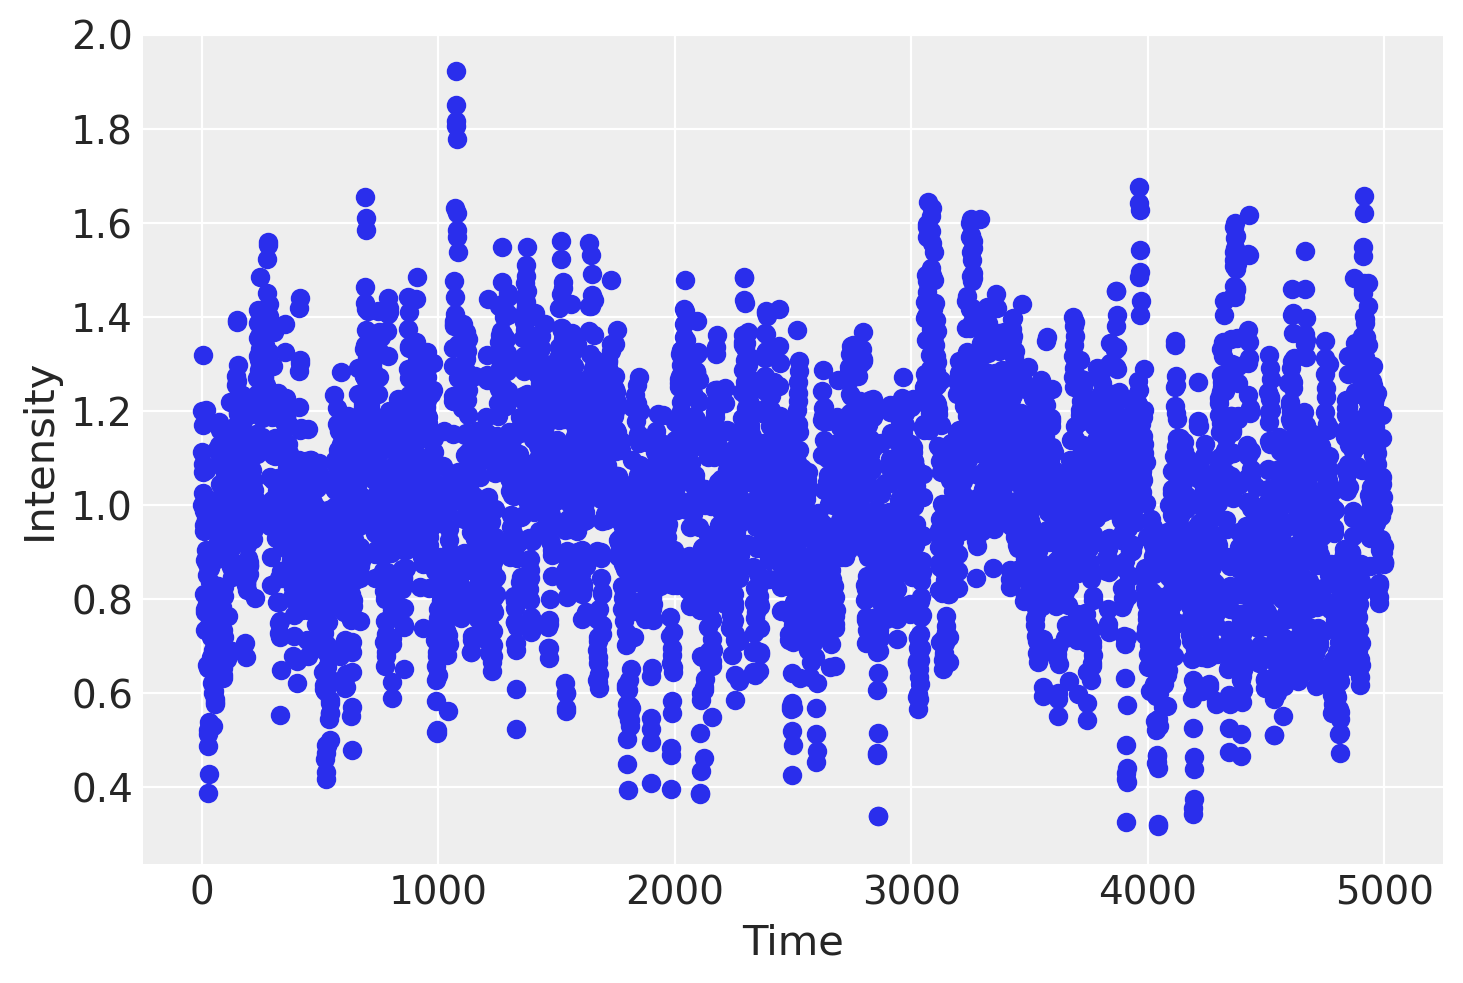

In [73]:
#Generate model data
phi = np.exp(-1/tao)
for i in np.arange(number_data_point-1):
    X[i+1]= innovation_mean + phi[i]*X[i] + innovation[i] # Data not normalized
    
X_normalized = X/mean_intensity

#Plot model data
plt.plot(np.arange(number_data_point),X_normalized,'o')
plt.xlabel('Time')
plt.ylabel('Intensity')
plt.show()

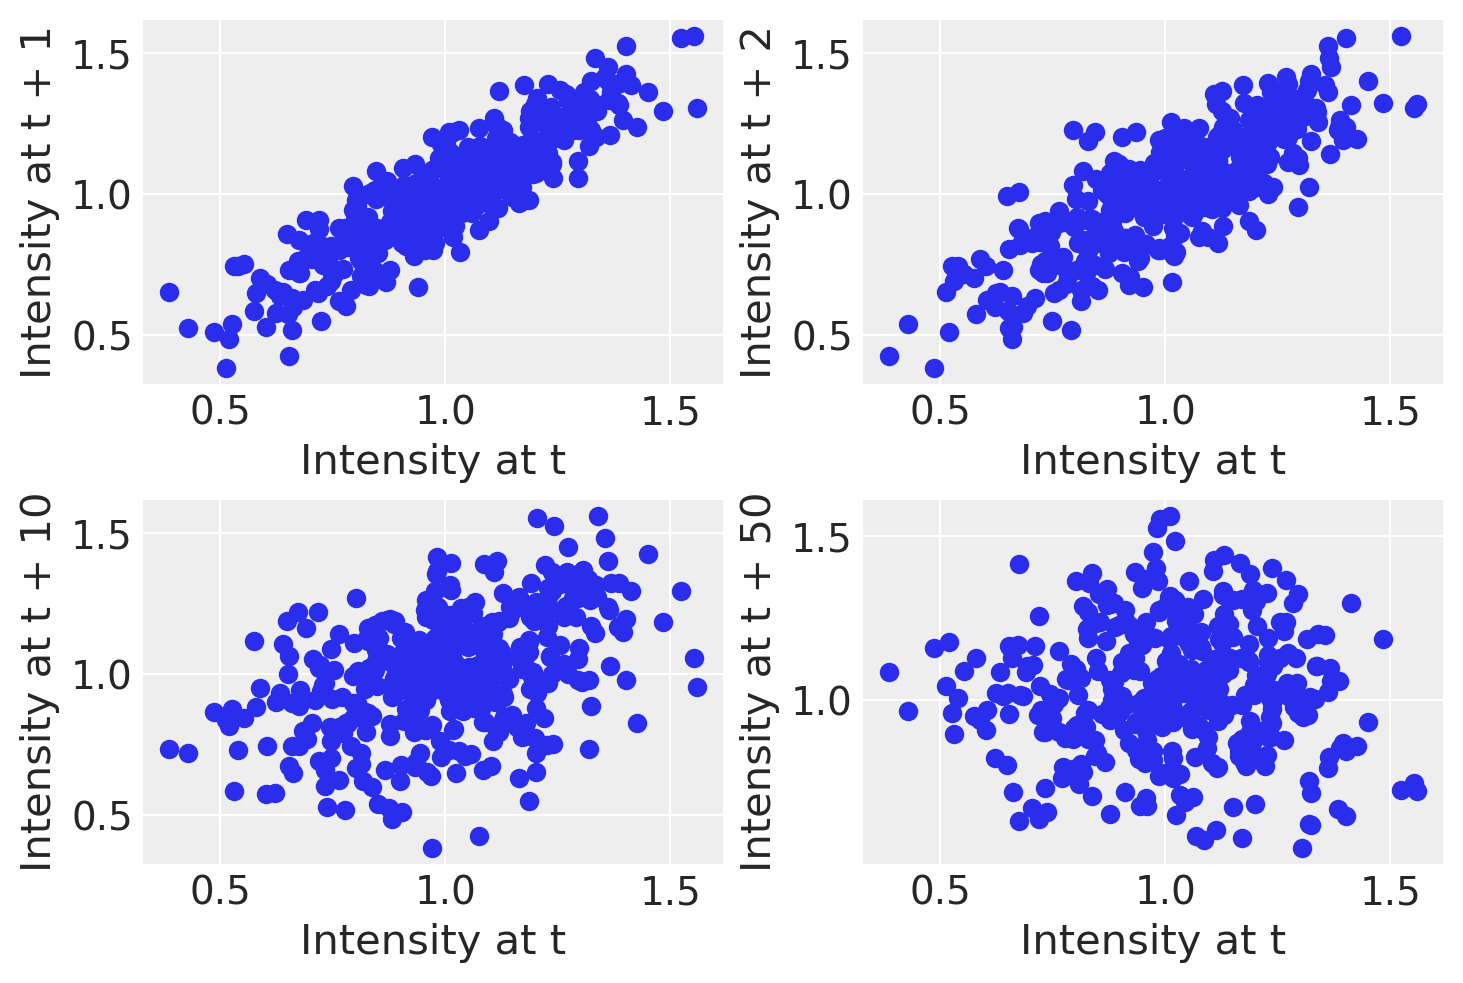

In [112]:
#Correlation between neighboring pts
averaged_pts = 400 
pth_neighbor = np.array([1,round(0.2*tao_mean),round(tao_mean),round(5*tao_mean)])
number_correlation_illustration = len(pth_neighbor)
for i in np.arange(number_correlation_illustration):
    plt.subplot(2,2,i+1)
    plt.plot(X_normalized[0:averaged_pts],X_normalized[pth_neighbor[i]:pth_neighbor[i]+averaged_pts],'o')
    plt.xlabel('Intensity at t')
    #plt.ylabel('$X_{t+1}$'.format(pth_neighbor))
    plt.ylabel('Intensity at t + {}'.format(pth_neighbor[i]))
plt.show()

/var/folders/4c/vpfj2cz13377t1cw_xxjyj4w0000gn/T/ipykernel_91013/209037652.py:19: RuntimeWarning: invalid value encountered in log
  plt.plot(lag_time,np.log(Autocorrelation),'o')


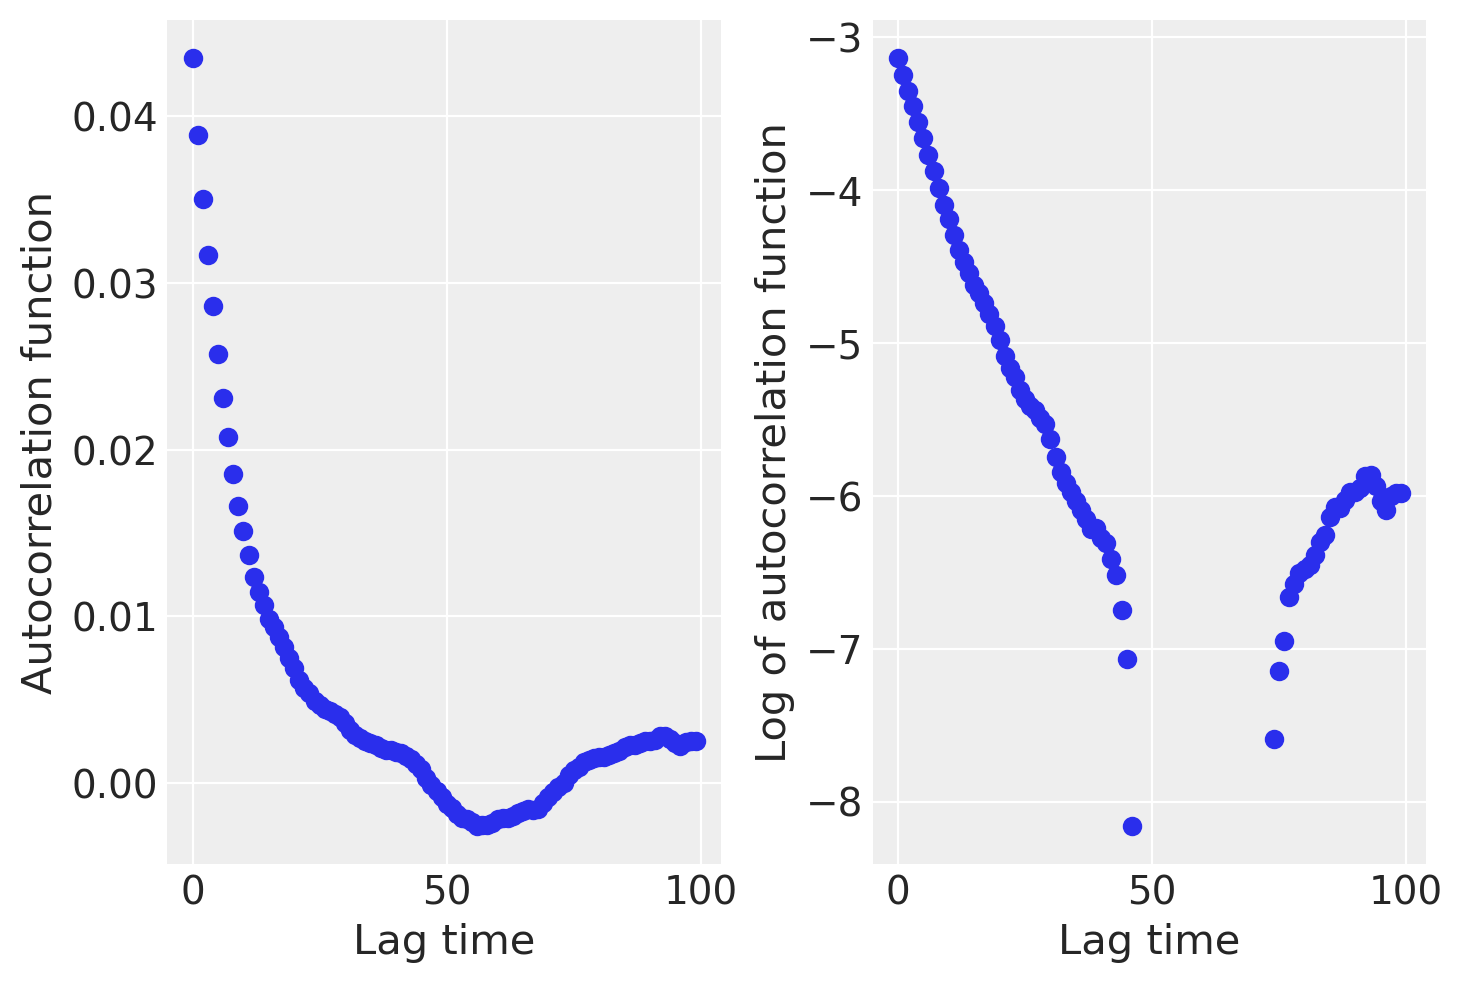

In [75]:
# Autocorrelation function
longest_lag_time = 100
lag_time = np.arange(longest_lag_time)
averaged_pts = 4000 #Need averaged_pts+lognes_lag_time < number_data_point
Intensity_matrix = np.zeros([longest_lag_time,averaged_pts])
Correlation_matrix = np.zeros([longest_lag_time,averaged_pts])

for i in lag_time:
    Intensity_matrix[i] = X_normalized[i:i+averaged_pts] 
    Correlation_matrix[i] = Intensity_matrix[0]*Intensity_matrix[i]

Autocorrelation = np.average(Correlation_matrix, axis = 1) / (np.average(Intensity_matrix[0])*np.average(Intensity_matrix, axis = 1)) - 1

plt.subplot(121)
plt.plot(lag_time,Autocorrelation,'o')   
plt.xlabel('Lag time')
plt.ylabel('Autocorrelation function')
plt.subplot(122)
plt.plot(lag_time,np.log(Autocorrelation),'o')   
plt.xlabel('Lag time')
plt.ylabel('Log of autocorrelation function')
plt.show()

In [76]:
# Bayesian parameter estimation with pymc3
ar1_model = pm.Model()

with ar1_model:
    
    # 'theta' is the 'phi' used in our generative model
    theta = pm.Normal("theta", mu = np.average(phi), sigma = 10*np.std(phi)) 
    # 'tao' is 1/(variance of innovation). As we use normalized data, this term has to be divided by intensity_mean squared
    tau = pm.Normal("tau", mu = 1/(innovation_std**2/intensity_mean**2), sigma = 10) 
    # process mean
    center = pm.Normal("center", mu=1, sigma= 10*np.sqrt(intensity_variance/intensity_mean**2)) # this is the mean of normalized data

    likelihood = pm.AR1("y", k=theta, tau_e=tau, observed = X_normalized - center)

In [77]:
estimate = pm.find_MAP(model = ar1_model)

In [78]:
with ar1_model:
    trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
    idata = az.from_pymc3(trace)

/var/folders/4c/vpfj2cz13377t1cw_xxjyj4w0000gn/T/ipykernel_91013/137214802.py:2: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(1000, tune=2000, init="advi+adapt_diag", random_seed=RANDOM_SEED)
Auto-assigning NUTS sampler...
Initializing NUTS using advi+adapt_diag...


Convergence achieved at 17100
Interrupted at 17,099 [8%]: Average Loss = 2,378.3
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [center, tau, theta]
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'
WARNING (theano.link.c.cmodule): install mkl with `conda install mkl-service`: No module named 'mkl'


Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 18 seconds.


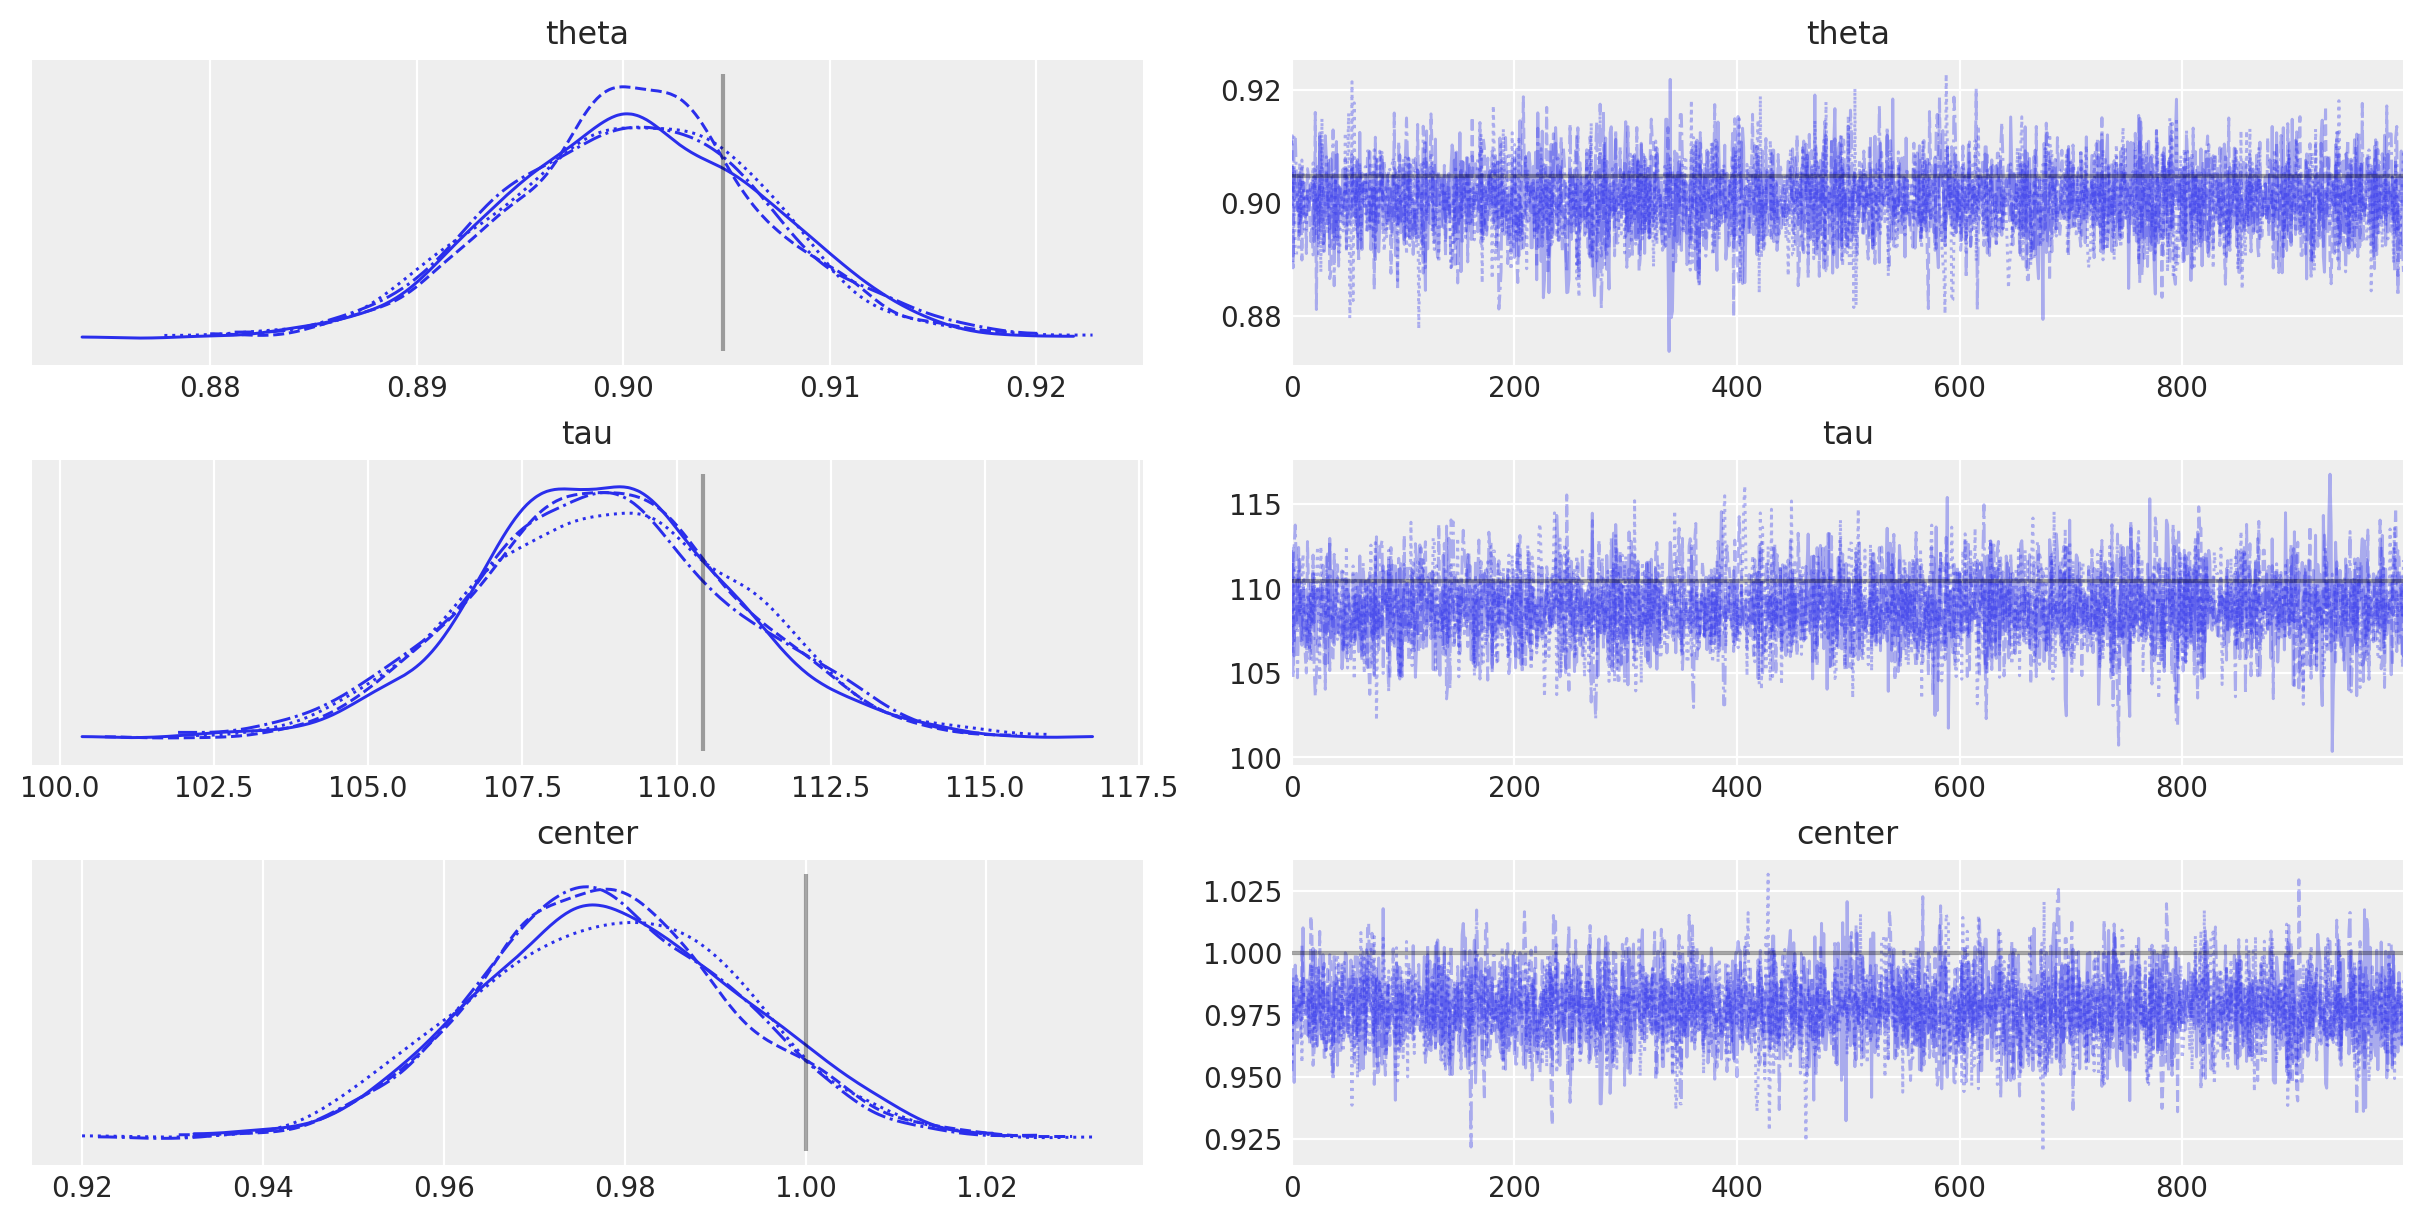

In [71]:
az.plot_trace(
    idata,
    lines=[
        ("theta", {}, np.exp(-1/tao_mean)),
        ("tau", {}, 1/(innovation_std**2/intensity_mean**2)),
        ("center", {}, 1),
    ],
);